**Modelo SqueezeNet1_0**<br>
Link do Colab: https://colab.research.google.com/drive/1cEQN5s5xRX1QLW35_bIinTWHoIVr9m6-

In [15]:
import kagglehub
from PIL import Image
import io
import random
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import os

In [16]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# Fixar o seed para reprodutividade
set_seed()

In [17]:
# Download latest version
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")

print("Path to dataset files:", path)

# Caminho para o dataset
train_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'

# Carrega o parquet
df = pd.read_parquet(train_path)

Path to dataset files: /kaggle/input/alzheimer-mri-disease-classification-dataset


In [18]:
# Label map
label_map = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}

In [19]:
# Transforms padrão para ResNet
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # padrão ImageNet
                        std=[0.229, 0.224, 0.225])
])

In [20]:
# Dataset customizado
class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_bytes = self.df.iloc[idx]['image']['bytes']
        label = self.df.iloc[idx]['label']
        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [21]:
# Criação do dataset e dataloader
dataset = AlzheimerDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [22]:
# Modelo com ResNet18 pré-treinada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo com AlexNet pré-treinada
model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)

# Substitui a camada final (classifier)
model.classifier[1] = torch.nn.Conv2d(512, 4, kernel_size=1)
model.num_classes = 4

model = model.to(device)

O SqueezeNet termina com <code>Conv2d</code> em vez de <code>Linear</code>, por isso o ajuste final é diferente do ResNet ou AlexNet.

Época 1/15: 100%|██████████| 320/320 [00:22<00:00, 14.18it/s]


Loss da época 1: 1.2588


Época 2/15: 100%|██████████| 320/320 [00:22<00:00, 14.30it/s]


Loss da época 2: 1.1179


Época 3/15: 100%|██████████| 320/320 [00:23<00:00, 13.68it/s]


Loss da época 3: 1.0291


Época 4/15: 100%|██████████| 320/320 [00:22<00:00, 14.17it/s]


Loss da época 4: 0.8887


Época 5/15: 100%|██████████| 320/320 [00:23<00:00, 13.47it/s]


Loss da época 5: 0.7163


Época 6/15: 100%|██████████| 320/320 [00:22<00:00, 14.10it/s]


Loss da época 6: 0.5834


Época 7/15: 100%|██████████| 320/320 [00:22<00:00, 14.18it/s]


Loss da época 7: 0.4972


Época 8/15: 100%|██████████| 320/320 [00:22<00:00, 14.18it/s]


Loss da época 8: 0.4065


Época 9/15: 100%|██████████| 320/320 [00:22<00:00, 14.17it/s]


Loss da época 9: 0.4254


Época 10/15: 100%|██████████| 320/320 [00:22<00:00, 14.34it/s]


Loss da época 10: 0.2973


Época 11/15: 100%|██████████| 320/320 [00:22<00:00, 14.17it/s]


Loss da época 11: 0.2303


Época 12/15: 100%|██████████| 320/320 [00:22<00:00, 14.10it/s]


Loss da época 12: 0.1914


Época 13/15: 100%|██████████| 320/320 [00:31<00:00, 10.23it/s]


Loss da época 13: 0.2010


Época 14/15: 100%|██████████| 320/320 [00:22<00:00, 14.27it/s]


Loss da época 14: 0.1630


Época 15/15: 100%|██████████| 320/320 [00:24<00:00, 13.15it/s]


Loss da época 15: 0.1186


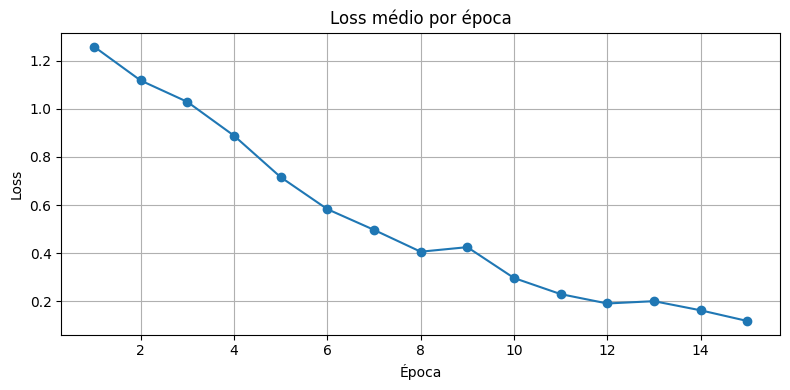

CPU times: user 5min 35s, sys: 1.66 s, total: 5min 37s
Wall time: 5min 51s


In [23]:
%%time
# Número de exemplos por classe, na ordem dos rótulos
class_counts = torch.tensor([172, 15, 634, 459], dtype=torch.float32)

# Frequência relativa (dividido pelo total)
total = class_counts.sum()
freqs = class_counts / total

# Peso = inverso da frequência
weights = 1.0 / freqs

# Normaliza para evitar explosão de gradientes
weights = weights / weights.sum()

# Enviar para GPU
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm

# Inicializa histórico
epoch_losses = []
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Loop por batch
    for images, labels in tqdm(dataloader, desc=f"Época {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Média da época
    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Loss da época {epoch+1}: {epoch_loss:.4f}")

# Grafico por época
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.title("Loss médio por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Caminho para o arquivo de teste
test_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'

# Lê o Parquet
df_test = pd.read_parquet(test_path)

# Cria o dataset e o dataloader de teste
test_dataset = AlzheimerDataset(df_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [25]:
# Coloque o modelo em modo de avaliação
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in tqdm(test_dataloader, desc="Avaliando"):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

Avaliando: 100%|██████████| 80/80 [00:03<00:00, 20.70it/s]


In [28]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Relatório completo por classe
print("\nModelo SqueezeNet1_0")
print("\nRelatório por classe:")
print(classification_report(y_true, y_pred, target_names=[label_map[i] for i in range(4)], zero_division=0))

Acurácia: 0.8125
Precisão: 0.8479
Revocação: 0.8125
F1-score: 0.7995

Modelo SqueezeNet1_0

Relatório por classe:
                    precision    recall  f1-score   support

     Mild_Demented       0.81      0.92      0.86       172
 Moderate_Demented       1.00      0.87      0.93        15
      Non_Demented       0.76      0.98      0.85       634
Very_Mild_Demented       0.98      0.54      0.69       459

          accuracy                           0.81      1280
         macro avg       0.89      0.83      0.84      1280
      weighted avg       0.85      0.81      0.80      1280



In [29]:
# Calcula a matriz
cm = confusion_matrix(y_true, y_pred)

# Converte para DataFrame com rótulos
cm_df = pd.DataFrame(cm, index=label_map.values(), columns=label_map.values())

print("Matriz de confusão:\n")
print(cm_df.to_string())

Matriz de confusão:

                    Mild_Demented  Moderate_Demented  Non_Demented  Very_Mild_Demented
Mild_Demented                 158                  0            12                   2
Moderate_Demented               0                 13             1                   1
Non_Demented                   10                  0           622                   2
Very_Mild_Demented             26                  0           186                 247
